In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import streamlit as st
import numpy as np
from PIL import Image
import os
import seaborn as sns

In [33]:
con = sqlite3.connect("spotify.db") # skapar en anslutning till en SQLite-databas där datan ska lagras

In [34]:
# läser in Kymias och Valmirs Spotify-data från CSV-filer
kymia_spotify = pd.read_csv('Kymia_Spotify.csv')
valmir_spotify = pd.read_csv('Valmir_Spotify.csv')

In [35]:
# lägger till en kolumn som anger vilken användare varje rad tillhör
kymia_spotify['user'] = 'Kymia'
valmir_spotify['user'] = 'Valmir'
# tar ett slumpmässigt urval av 21 650 rader från Valmirs data för att kunna skapa en mindre dataset
valmir_sample = valmir_spotify.sample(21650)

In [36]:
merged_data = pd.concat([kymia_spotify, valmir_spotify], ignore_index=True) # slår ihop Kymias och Valmirs data till en gemensam dataset

In [37]:
merged_data_sample = pd.concat([kymia_spotify, valmir_sample], ignore_index=True) # slår ihop Kymias data och dValmirs sample data för en mer balanserad dataset

In [ ]:
# sparar den fullständiga datan i SQLite-databasen "spotify_data"
# om tabellen redan finns ersätts den med den nya datan
merged_data.to_sql("spotify_data", con, if_exists="replace")
# sparar Valmirs sample data i SQLite-databasen "spotify_data_sample"
merged_data_sample.to_sql("spotify_data_sample", con, if_exists="replace")

43300

In [39]:
print(merged_data.head()) # skriver ut dom 5 första raderna i merged_data

            endTime artistName      trackName  msPlayed   user
0  2024-01-19 20:40     Moha K  Besoin de toi     18624  Kymia
1  2024-01-20 14:04   DYSTINCT             La    148328  Kymia
2  2024-01-20 14:06     Oualid       Nabghiha    140666  Kymia
3  2024-01-20 14:09      Makar   Je M'en Fous    177361  Kymia
4  2024-01-20 14:11      Masri    El 7ob Sa3b    142800  Kymia


In [40]:
print(merged_data.isnull().sum()) ## kollar ifall vi har några null värden

endTime       0
artistName    0
trackName     0
msPlayed      0
user          0
dtype: int64


In [41]:
print(merged_data.dtypes) ## kollar datatypen

endTime       object
artistName    object
trackName     object
msPlayed       int64
user          object
dtype: object


In [42]:
merged_data["user"].value_counts()

user
Valmir    51047
Kymia     21650
Name: count, dtype: int64

In [43]:
# Question 1

# SQL-query för att räkna total lyssningstid per artist och användare
query = """
SELECT user, artistName, SUM(msPlayed) as total_playtime
FROM spotify_data
GROUP BY user, artistName
ORDER BY user, total_playtime DESC
"""

# läser in resultatet från queryn till en Pandas DataFrame
user_artist_playtime = pd.read_sql(query, con)

# omvandlar total speltid från millisekunder till timmar för bättre läsbarhet
user_artist_playtime["total_playtime_hours"] = user_artist_playtime["total_playtime"] / (1000 * 60 * 60)

# hittar topp 3 artister per användare baserat på speltid
top3_artists_user = (
    user_artist_playtime.groupby("user")
    .apply(lambda x: x.nlargest(3, "total_playtime_hours"))  # väljer de 3 största värdena för varje användare
    .reset_index(drop=True)  # återställer indexet efter groupby-operationen
)

# bildkatalog där artistbilder förväntas finnas
image_dir = "images"

# hämtar unika användarnamn från datan
users = top3_artists_user["user"].unique()

# filtrerar fram data för specifika användare
valmir_top_artists = top3_artists_user[top3_artists_user["user"] == "Valmir"]
kymia_top_artists = top3_artists_user[top3_artists_user["user"] == "Kymia"]

# skapar två kolumner för att visa resultaten sida vid sida i Streamlit
left_col, right_col = st.columns(2)

with left_col:
    st.subheader("Valmir's Top 3 Artists")

with right_col:
    st.subheader("Kymia's Top 3 Artists")

# itererar genom topp 3-artisterna för Valmir och Kymia samtidigt
for (_, valmir_row), (_, kymia_row) in zip(valmir_top_artists.iterrows(), kymia_top_artists.iterrows()):
    left_col, right_col = st.columns(2)  # Skapar nya kolumner för varje rad i loopen

    # visar Valmirs artister och bilder
    with left_col:
        if valmir_row["artistName"]:  # säkerställer att artistnamn finns
            listening_hours = valmir_row["total_playtime_hours"]
            image_path = os.path.join(image_dir, f"{valmir_row['artistName']}.jpeg")

            # kontrollerar om bilden finns och visar den, annars skriver ut ett meddelande
            if os.path.exists(image_path):
                st.image(image_path, caption=f"{valmir_row['artistName']} - {listening_hours:.2f} hours", width=150)
            else:
                st.write(f"Image missing for: {valmir_row['artistName']}")

    # visar Kymias artister och bilder
    with right_col:
        if kymia_row["artistName"]:  # säkerställer att artistnamn finns
            listening_hours = kymia_row["total_playtime_hours"]
            image_path = os.path.join(image_dir, f"{kymia_row['artistName']}.jpeg")

            # kontrollerar om bilden finns och visar den, annars skriver ut ett meddelande
            if os.path.exists(image_path):
                st.image(image_path, caption=f"{kymia_row['artistName']} - {listening_hours:.2f} hours", width=150)
            else:
                st.write(f"Image missing for: {kymia_row['artistName']}")


/var/folders/4l/gfjlj22s475gkdvzzlfg1v0m0000gn/T/ipykernel_10402/610591081.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nlargest(3, "total_playtime_hours"))  # väljer de 3 största värdena för varje användare


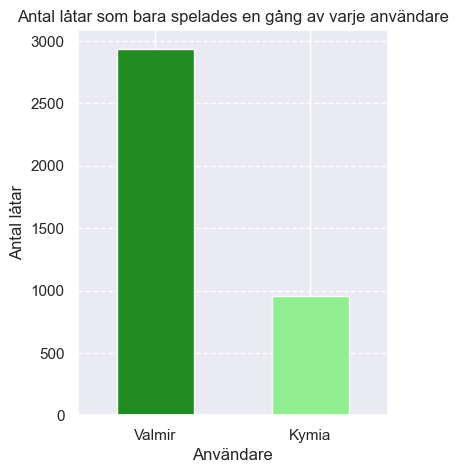

                trackName     artistName    user
0              #1 (Intro)         Future  Valmir
1              #thatPOWER      will.i.am  Valmir
2         +212 (feat. 23)  Jonas Benyoub  Valmir
3                     +57        KAROL G  Valmir
4                  +Linda          Dalex   Kymia
...                   ...            ...     ...
3891                 واقع  Rashad ComBal  Valmir
3892         ‘87 Stingray     Tory Lanez  Valmir
3893  “Carlito” Chapter 3          Lluni  Valmir
3894   “Omerta” Chapter 1          Lluni  Valmir
3895    ⁠LUCES DE COLORES    Omar Courtz  Valmir

[3896 rows x 3 columns]


In [44]:
#Fråga2
# Finns det låtar som spelats endast en gång av alla användare och aldrig igen?

# .size() för att räkna antal spelningar varje låt har
# grouby så att alla inspelningar för samma låt hamnar i samma grupp
# .reset_index behövs pga groupby för att göra det enklare att läsa av restulatet, då groupby skapar sina egna grupper
# utan reset_index används låtarna som index
play_counts = merged_data.groupby('trackName').size().reset_index(name='play_count')

# filtrera föregående så man får ut låtarna som spelats endast en gång bara
played_once = play_counts[play_counts['play_count'] == 1]

# för att vi ska hämta detaljer om låten då vi tappar all info utöver låtnamn pga föregående, såsom artistname och user
# då får vi tillbaka den kopplade infon med pd.merge 
played_once_info = pd.merge(played_once, merged_data, on='trackName')

# här får vi ut endast de unika låtarna med kopplad info och droppar duplicates ifall det skulle finnas några
unique_songs_played_once = played_once_info[['trackName', 'artistName', 'user']].drop_duplicates()

plt.figure(figsize=(4, 5)) # storleken på självaste figuren, bredd x höjd
# unique_songs_played_once['user'].value_counts().plot(kind='bar', color='orange') # informationen som man får ut från diagrammet och vilken typ & färg
user_colors = {'Valmir': 'forestgreen', 'Kymia': 'lightgreen'}
colors = unique_songs_played_once['user'].map(user_colors)
unique_songs_played_once['user'].value_counts().plot(kind='bar', color=[user_colors[user] for user in unique_songs_played_once['user'].value_counts().index]) # informationen som man får ut från diagrammet och vilken typ & färg
plt.title("Antal låtar som bara spelades en gång av varje användare")
plt.ylabel("Antal låtar")
plt.xlabel("Användare")
plt.xticks(rotation=0) # så att namnen på användare visas rakt utan rotation
plt.grid(axis='y', linestyle='--') # visas endast på y-axeln och rutnätet ritas som steckande linjer vilket förenklar läsningen av diagrammet
plt.show() # behövs egentligen inte bara att den visar diagrammet före listan

print(unique_songs_played_once)


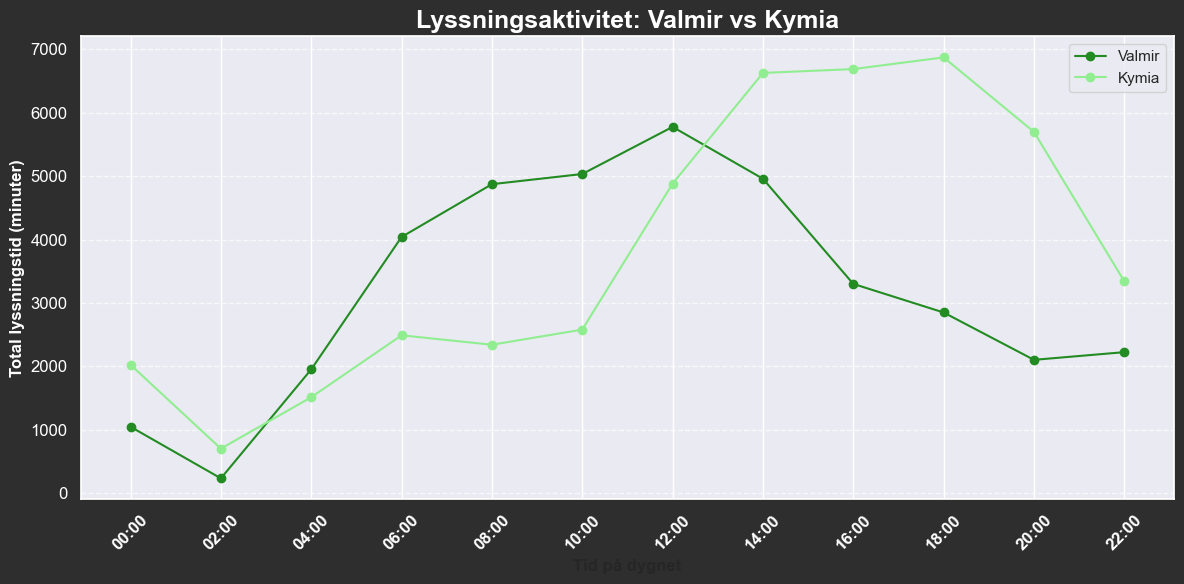

In [45]:
# Question 3: Analys av lyssningsmönster baserat på tid på dygnet

# extraherar timmen från kolumnen 'endTime' för att analysera vid vilken tid lyssning sker
merged_data_sample['hour'] = pd.to_datetime(merged_data_sample['endTime']).dt.hour

# klassificerar lyssningsaktivitet i 'Dagtid' (06:00-22:00) och 'Nattid' (22:00-06:00)
merged_data_sample['time_of_day'] = merged_data_sample['hour'].apply(
    lambda x: 'Dagtid' if 6 <= x < 22 else 'Nattid'
)

# skapar 2-timmars intervall för att gruppera lyssningsaktivitet
merged_data_sample['hour_bin'] = (merged_data_sample['hour'] // 2) * 2  # Rundar ned till närmaste jämna timme

# filtrerar data för varje användare separat
valmir_data = merged_data_sample[merged_data_sample['user'] == 'Valmir']
kymia_data = merged_data_sample[merged_data_sample['user'] == 'Kymia']

# Valmirs lyssningsdata efter 2-timmarsintervall och beräknar total lyssningstid
valmir_activity = (
    valmir_data.groupby('hour_bin')['msPlayed'].sum().reset_index()
)
# omvandlar total lyssningstid från millisekunder till minuter
valmir_activity['listening_time_minutes'] = valmir_activity['msPlayed'] / (1000 * 60)

# Kymias lyssningsdata efter 2-timmarsintervall och beräknar total lyssningstid
kymia_activity = (
    kymia_data.groupby('hour_bin')['msPlayed'].sum().reset_index()
)
# omvandlar total lyssningstid från millisekunder till minuter
kymia_activity['listening_time_minutes'] = kymia_activity['msPlayed'] / (1000 * 60)

# sätter upp stilen för visualiseringen
sns.set(style='darkgrid')
plt.figure(figsize=(12, 6))  # Sätter figurens storlek

# visualisering för Valmirs lyssningsaktivitet över dygnet
plt.plot(
    valmir_activity['hour_bin'], 
    valmir_activity['listening_time_minutes'], 
    label='Valmir', 
    color='forestgreen', 
    marker='o'
)

# visualisering för Kymias lyssningsaktivitet över dygnet
plt.plot(
    kymia_activity['hour_bin'], 
    kymia_activity['listening_time_minutes'], 
    label='Kymia', 
    color='lightgreen', 
    marker='o'
)

# anpassar utseendet på diagrammet
plt.title('Lyssningsaktivitet: Valmir vs Kymia', fontweight='bold', fontsize=18, color='white')
plt.xlabel('Tid på dygnet', fontweight='bold', fontsize=12)
plt.ylabel('Total lyssningstid (minuter)', fontweight='bold', fontsize=12, color='white')

# formaterar x-axelns etiketter för att visa varannan timme
plt.xticks(
    range(0, 24, 2), 
    labels=[f'{hour:02d}:00' for hour in range(0, 24, 2)], 
    rotation=45, 
    fontweight='bold', 
    fontsize=12
)

# lägger till en legend för att skilja på användarna
plt.legend()
# justerar rutnät och axelinställningar
plt.xticks(fontweight='bold', fontsize=12, color='white')
plt.grid(axis='y', linestyle='--', alpha=0.7, color='white')
plt.yticks(fontsize=12, color='white')

# sätter en mörk bakgrundsfärg för att passa temat
plt.gcf().patch.set_facecolor('#2e2e2e')
plt.tight_layout()
plt.show()


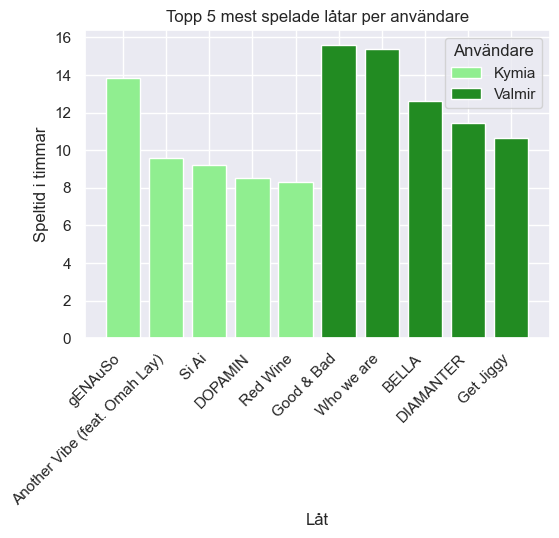

In [46]:
# Question 4
## top 5 mest spelade låtar (i timmar) respektive användare

top_songs = (merged_data.groupby(['user', 'trackName'], as_index=False)['msPlayed'].sum())
top_songs_sorted = top_songs.sort_values(['user', 'msPlayed'], ascending=[True, False])
top_5_songs_per_user = top_songs_sorted.groupby('user').head(5)

plt.figure(figsize=(6, 4))
user_colors = {'Valmir': 'forestgreen', 'Kymia': 'lightgreen'} # för att själv bestämma färgerna då det inte går att göra det på det vanliga sättet med tanke på att det är två olika användare
for user in top_5_songs_per_user['user'].unique(): # Itererar så att vi får en lista med unika users och for user in ser till så vi kan arbeta seperat med varje user
    user_data = top_5_songs_per_user[top_5_songs_per_user['user'] == user] # filtrerar datan från föregående iteration för just en spicifik användare
    plt.bar(user_data['trackName'], # hämtar låtnamn
            user_data['msPlayed'] / (1000 * 60 * 60), # genom att dividera ms med (1000*60*60 = 3,6000,000 = en timme) omvanldas ms till timmar
            label=user, # användarna identifieras i legend
            color=user_colors[user])  
    # plt.bar är inuti loopen pga att det sker en iteration över unika användare och därav behöver vi unika staplar till varje användare
    # tar vi ut plt.bar från loopen så får vi ut ofiltrerad data där man inte kan skilja mellan användarna
plt.title('Topp 5 mest spelade låtar per användare')
plt.xlabel('Låt')
plt.ylabel('Speltid i timmar')
plt.xticks(rotation=45, ha='right') # ha ser till så texten inte överlappar med andra texter och placeras rätt
plt.legend(title='Användare') # den lilla rutan som förklrar färgerna för respektive användare
plt.show()

          artistName     trackName  shared_count  total_playtime
0          C.Gambino    Who we are             2        55396092
1          C.Gambino     DIAMANTER             2        41564209
2               Nuqi      Motorväg             2        41498196
3         T.G Boogie     Get Jiggy             2        38224814
4          Ceasar DD       DOPAMIN             2        37695294
...              ...           ...           ...             ...
1004  Rauw Alejandro        LOKERA             2            2517
1005             24K          Bars             2            2302
1006            Rina     Addiction             2            2198
1007     Kizz Daniel  Boys Are Bad             2            2010
1008            Zerb      Addicted             2            1103

[1009 rows x 4 columns]
   artistName   trackName  shared_count  total_playtime  \
0   C.Gambino  Who we are             2        55396092   
1   C.Gambino   DIAMANTER             2        41564209   
2        Nuqi    M

/var/folders/4l/gfjlj22s475gkdvzzlfg1v0m0000gn/T/ipykernel_10402/2717697071.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topfive_shared_data.loc[:, 'total_playtime_minutes'] = topfive_shared_data['total_playtime'] / (1000 * 60)


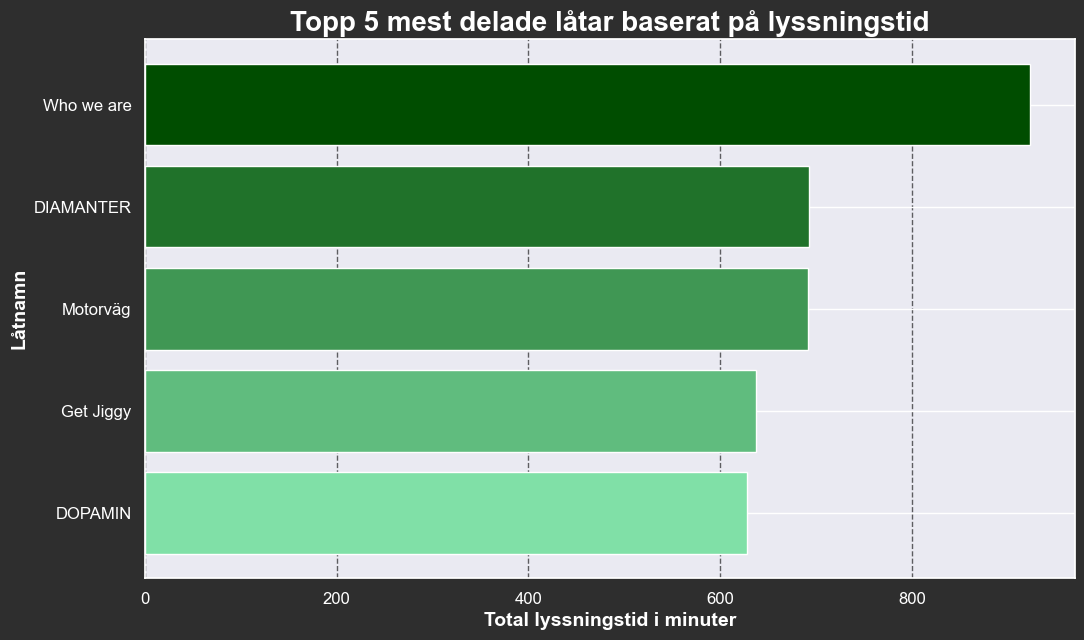

   artistName   trackName  shared_count  total_playtime_minutes
0   C.Gambino  Who we are             2              923.268200
1   C.Gambino   DIAMANTER             2              692.736817
2        Nuqi    Motorväg             2              691.636600
3  T.G Boogie   Get Jiggy             2              637.080233
4   Ceasar DD     DOPAMIN             2              628.254900


In [47]:
# Question 5: Topp 5 mest gemensamma låtar (lyssnade av flera användare) -- VERSION !

# SQL-query för att hämta låtar som lyssnats på av mer än en användare
query = """
SELECT artistName, trackName,
       COUNT(DISTINCT user) AS shared_count,  -- räknar hur många olika användare som lyssnat på låten
       SUM(msPlayed) as total_playtime       -- summerar den totala lyssningstiden för låten
FROM spotify_data
GROUP BY artistName, trackName
HAVING shared_count > 1                      -- filtrerar låtar som minst två användare har lyssnat på
ORDER BY total_playtime DESC                 -- sorterar efter total lyssningstid i fallande ordning
"""

# läser in resultatet från queryn till en Pandas DataFrame
shared_data = pd.read_sql(query, con)
print(shared_data)  # Skriver ut den fullständiga listan över gemensamma låtar

# hämtar de 5 mest spelade gemensamma låtarna
topfive_shared_data = shared_data.head()

# omvandlar total lyssningstid från millisekunder till minuter
topfive_shared_data.loc[:, 'total_playtime_minutes'] = topfive_shared_data['total_playtime'] / (1000 * 60)
print(topfive_shared_data)  # Skriver ut de 5 mest lyssnade låtarna med uppdaterad lyssningstid

# visualisering
sns.set(style="darkgrid")
plt.figure(figsize=(12, 7))

# skapar en grön färgpalett för diagrammet
green_palette = sns.blend_palette(["#004d00", "#80e0a7"], n_colors=len(topfive_shared_data))

# skapar ett horisontellt stapeldiagram där låtarna sorteras efter total lyssningstid
bars = plt.barh(
    topfive_shared_data['trackName'],  # låtens namn på y-axeln
    topfive_shared_data['total_playtime_minutes'],  # lyssningstid i minuter på x-axeln
    color=green_palette  # använder färgpaletten fån tidigare
)

# sätter etiketter och titel för diagrammet
plt.xlabel('Total lyssningstid i minuter', fontsize=14, fontweight='bold', color='white')
plt.ylabel('Låtnamn', fontsize=14, fontweight='bold', color='white')
plt.title('Topp 5 mest delade låtar baserat på lyssningstid', fontsize=20, fontweight='bold', color='white')

# vänder y-axeln så att den mest spelade låten visas överst
plt.gca().invert_yaxis()

# anpassar utseendet för ett mörkt tema
plt.grid(axis='x', linestyle='--', alpha=0.6, color='black')
plt.xticks(fontsize=12, color='white')
plt.yticks(fontsize=12, color='white')
plt.gcf().patch.set_facecolor('#2e2e2e')

plt.show()
print(topfive_shared_data[['artistName', 'trackName', 'shared_count', 'total_playtime_minutes']])


/var/folders/4l/gfjlj22s475gkdvzzlfg1v0m0000gn/T/ipykernel_10402/3445427332.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_artist['YearMonth'] = df_artist['endTime'].dt.to_period('M')


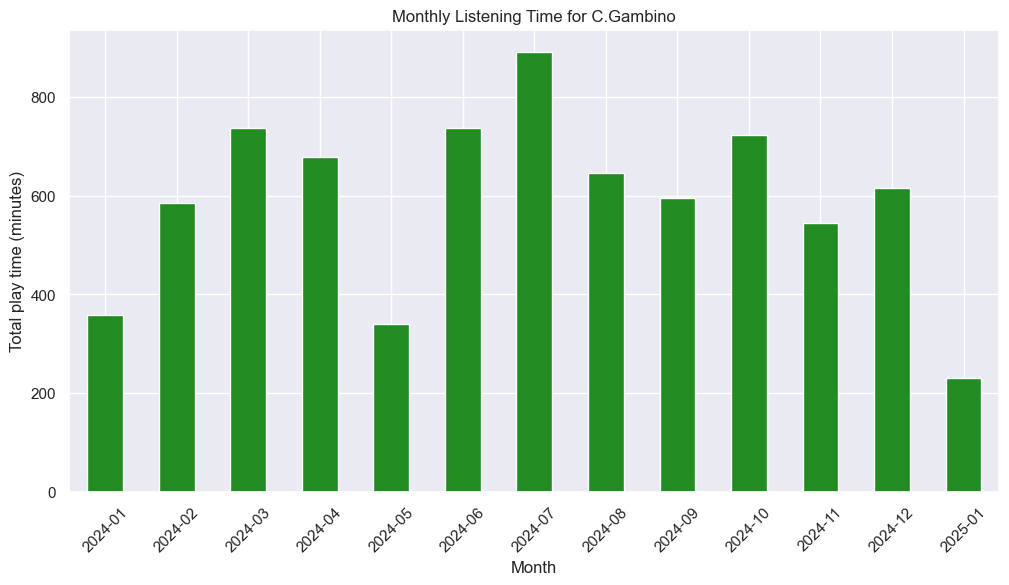

In [48]:
# Question 6
## Valmir
valmir_spotify['endTime'] = pd.to_datetime(valmir_spotify['endTime'])
my_artist = 'C.Gambino'
df_artist = valmir_spotify[valmir_spotify['artistName'] == my_artist]
df_artist['YearMonth'] = df_artist['endTime'].dt.to_period('M')
monthly_data = df_artist.groupby('YearMonth')['msPlayed'].sum()
monthly_data_in_minutes = monthly_data / 60000
monthly_data_in_minutes = pd.to_numeric(monthly_data_in_minutes, errors='coerce')
 
plt.figure(figsize=(12, 6))
monthly_data_in_minutes.plot(kind='bar', color='forestgreen')
plt.title('Monthly Listening Time for C.Gambino')
plt.xlabel('Month')
plt.ylabel('Total play time (minutes)')
plt.xticks(
    ticks=range(len(monthly_data_in_minutes)),
    labels=[str(period) for period in monthly_data_in_minutes.index],
    rotation=45)
plt.show()

/var/folders/4l/gfjlj22s475gkdvzzlfg1v0m0000gn/T/ipykernel_10402/1456530407.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_artist['YearMonth'] = df_artist['endTime'].dt.to_period('M')


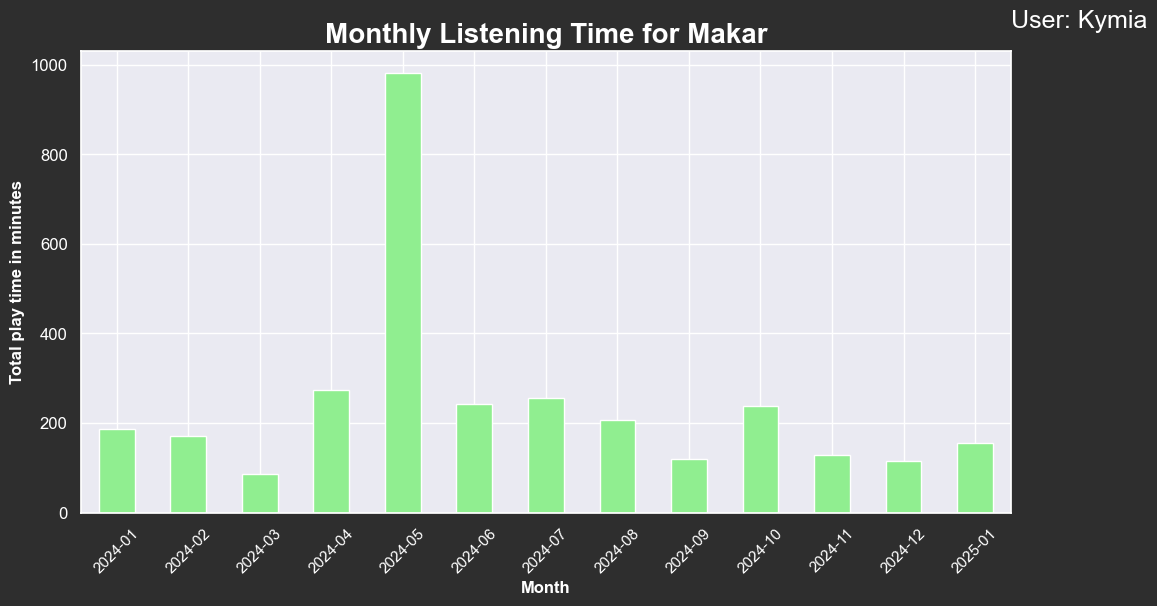

In [49]:
# Question 6
## Kymia
kymia_spotify['endTime'] = pd.to_datetime(kymia_spotify['endTime'])
my_artist = 'Makar'
df_artist = kymia_spotify[kymia_spotify['artistName'] == my_artist]
df_artist['YearMonth'] = df_artist['endTime'].dt.to_period('M')
monthly_data = df_artist.groupby('YearMonth')['msPlayed'].sum()
monthly_data_in_minutes = monthly_data / 60000
monthly_data_in_minutes = pd.to_numeric(monthly_data_in_minutes, errors='coerce')
 
plt.figure(figsize=(12, 6))
monthly_data_in_minutes.plot(kind='bar', color='lightgreen')
plt.title('Monthly Listening Time for Makar', fontsize=20, color='white', fontweight='bold')
plt.xlabel('Month', color='white', fontweight='bold', fontsize=12)
plt.ylabel('Total play time in minutes', color='white', fontweight='bold', fontsize=12)
plt.xticks(
    ticks=range(len(monthly_data_in_minutes)),
    labels=[str(period) for period in monthly_data_in_minutes.index],
    rotation=45,
    color='white')
plt.gca().text(1, 1.05, "User: Kymia", transform=plt.gca().transAxes, fontsize=18, color='white')
plt.yticks(fontsize=12, color='white')
plt.gcf().patch.set_facecolor('#2e2e2e')
plt.show()

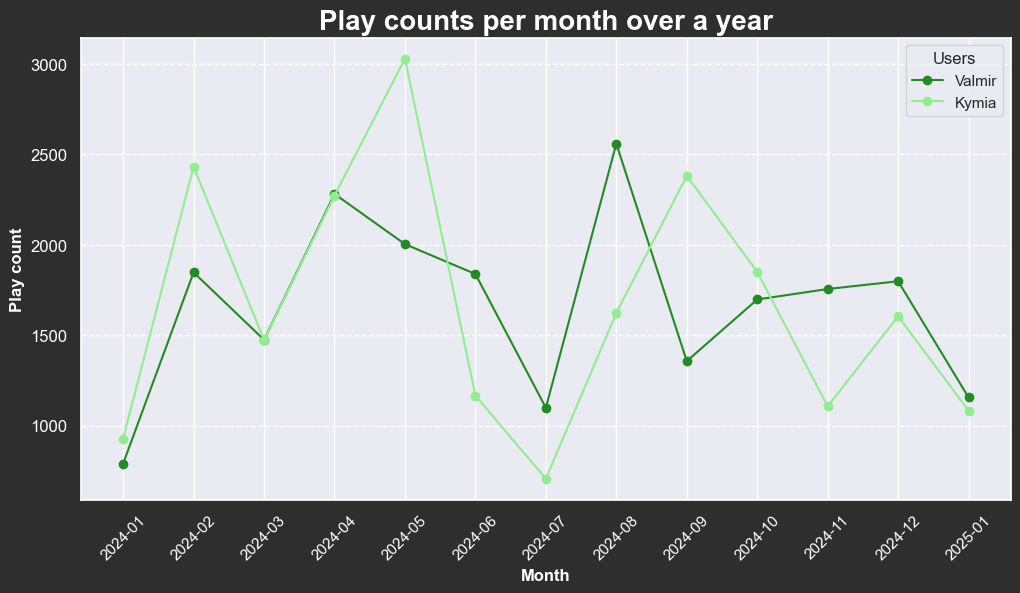

In [50]:
# Question 7 
merged_data['endTime'] = pd.to_datetime(merged_data['endTime'])
merged_data['month'] = merged_data['endTime'].dt.to_period('M')
merged_data = merged_data[merged_data['endTime'] >= '2024-01-01']
valmir_data = merged_data[merged_data['user'] == 'Valmir'].sample(n=21650, random_state=42)
valmir_monthly = valmir_data.groupby('month').size()
kymia_monthly = merged_data[merged_data['user'] == 'Kymia'].groupby('month').size()

plt.figure(figsize=(12, 6))
plt.plot(valmir_monthly.index.astype(str), valmir_monthly, label='Valmir', marker='o', color='forestgreen')
plt.plot(kymia_monthly.index.astype(str), kymia_monthly, label='Kymia', marker='o', color='lightgreen')
plt.title('Play counts per month over a year', fontsize=20, color='white', fontweight='bold')
plt.xlabel('Month', color='white', fontweight='bold', fontsize=12)
plt.ylabel('Play count', color='white', fontweight='bold', fontsize=12)
plt.xticks(rotation=45, color='white')
plt.legend(title='Users')
plt.grid(axis='y', linestyle='--')
plt.yticks(fontsize=12, color='white')
plt.gcf().patch.set_facecolor('#2e2e2e')
plt.show()

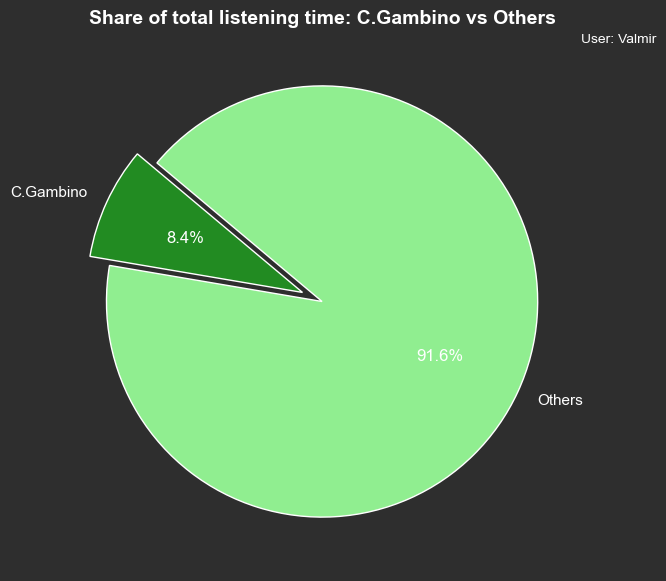

In [51]:
# Question 8
## Valmir
# slå ihop lyssningstiden för varje artist
artist_time = valmir_spotify.groupby('artistName')['msPlayed'].sum().sort_values(ascending=False)
# för att kunna identifiera topartisten och lyssningstiden för just denna artist
top_artist = artist_time.idxmax()
top_artist_time = artist_time.max()
# total lyssningstid
total_time = artist_time.sum()
# Topartistens andel av all speltid
top_artist_listening_time = (top_artist_time / total_time) * 100

lables = [top_artist, 'Others']
sizes = [top_artist_time, total_time - top_artist_time]
colors = ['forestgreen', 'lightgreen']
explode = (0.1, 0)
plt.figure(figsize=(7, 7))
plt.pie(sizes, explode=explode, labels=lables, colors=colors, autopct='%1.1f%%', startangle=140, textprops={'color': 'white'})
plt.title(f"Share of total listening time: {top_artist} vs Others", fontsize=14, fontweight='bold', color='white')
plt.text(1.2, 1.2, "User: Valmir", fontsize=10, color='white')
plt.yticks(fontsize=12, color='white')
plt.gcf().patch.set_facecolor('#2e2e2e')
plt.show()

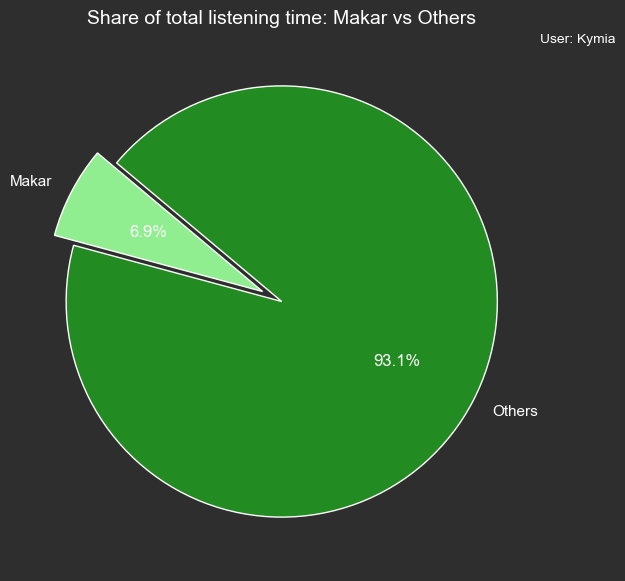

In [52]:
# Question 8
## Kymia
artist_time = kymia_spotify.groupby('artistName')['msPlayed'].sum().sort_values(ascending=False)
top_artist = artist_time.idxmax()
top_artist_time = artist_time.max()
total_time = artist_time.sum()
top_artist_listening_time = (top_artist_time / total_time) * 100

lables = [top_artist, 'Others']
sizes = [top_artist_time, total_time - top_artist_time]
colors = ['lightgreen', 'forestgreen']
explode = (0.1, 0)
plt.figure(figsize=(7, 7))
plt.pie(sizes, explode=explode, labels=lables, colors=colors, autopct='%1.1f%%', startangle=140, textprops={'color': 'white'})
plt.title(f"Share of total listening time: {top_artist} vs Others", fontsize=14, color='white')
plt.text(1.2, 1.2, "User: Kymia", fontsize=10, color='white')
plt.yticks(fontsize=12, color='white')
plt.gcf().patch.set_facecolor('#2e2e2e')
plt.show()

460817145
5002514611
83375.24351666667
7680.28575


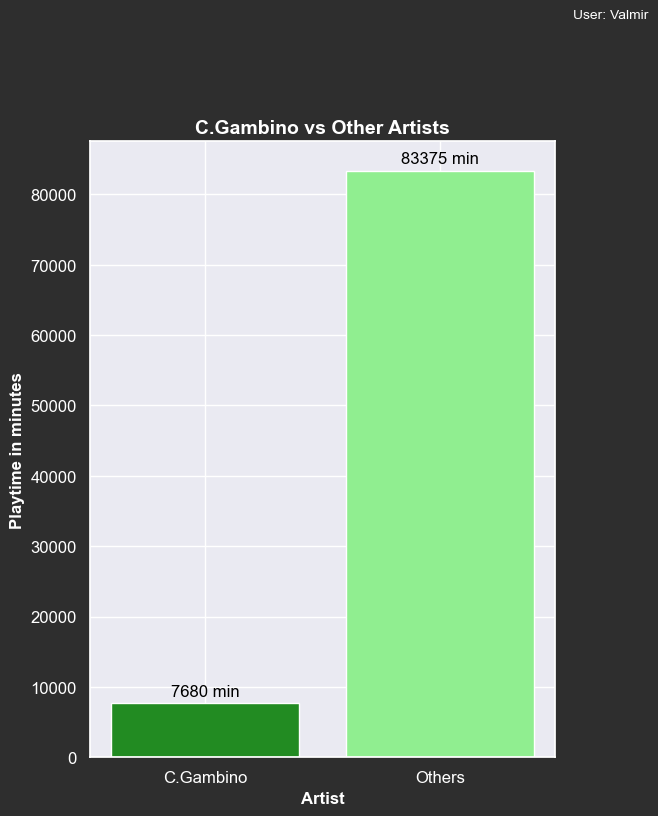

In [53]:
# Question 9
## Valmir
C_Gambino = valmir_spotify[valmir_spotify['artistName'] == 'C.Gambino']
cg_ms = C_Gambino['msPlayed'].sum()
print(cg_ms)
Others = valmir_spotify[valmir_spotify['artistName'] != 'C.Gambino']
others_ms_artsiter = Others['msPlayed'].sum()
print(others_ms_artsiter)
total_ms = 5002514611 
total_others = total_ms / 60000
print(total_others)
total_cg_ms = 460817145 
total_ms_cg = total_cg_ms / 60000
print(total_ms_cg)

total_playtime = [total_ms_cg, total_others]
labels = ['C.Gambino', 'Others']
fig, ax = plt.subplots(figsize=(6, 8))
ax.bar(labels, total_playtime, color=['forestgreen', 'lightgreen'])
plt.xlabel('Artist', color='white', fontweight='bold', fontsize=12)
plt.ylabel('Playtime in minutes', color='white', fontweight='bold', fontsize=12)
plt.title('C.Gambino vs Other Artists', fontweight='bold', fontsize=14, color='white')
for i, value in enumerate(total_playtime):
    plt.text(i, value + 1000, f'{value:.0f} min', ha='center', fontsize=12, color='black')
ax.text(1.2, 1.2, "User: Valmir", fontsize=10, ha='right', transform=ax.transAxes, color='white')
plt.xticks(fontsize=12, color='white')
plt.yticks(fontsize=12, color='white')
plt.gcf().patch.set_facecolor('#2e2e2e')
plt.show()

189875904
2557108282
42618.471366666665
3164.5984


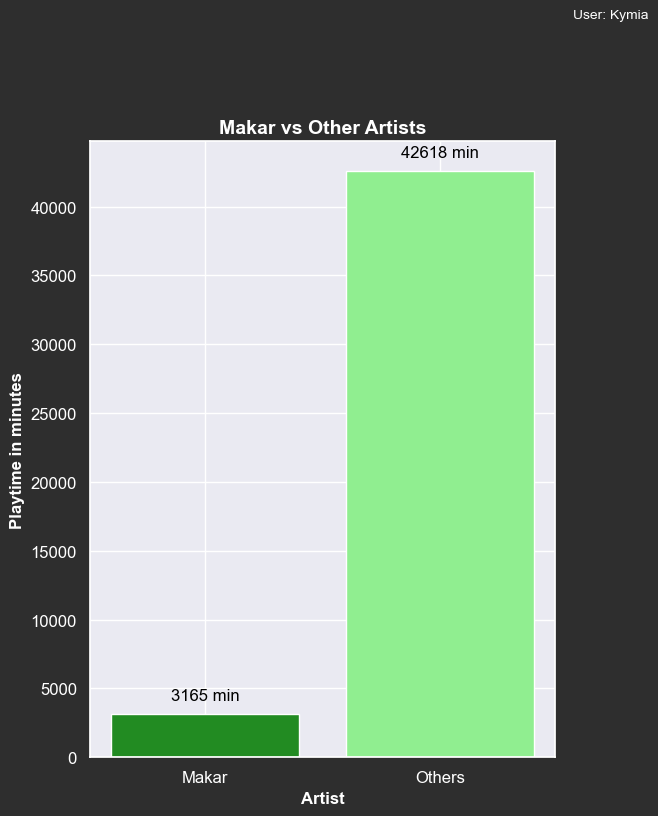

In [54]:
# Question 9
## Kymia
Makar = kymia_spotify[kymia_spotify['artistName'] == 'Makar']
makar_ms = Makar['msPlayed'].sum()
print(makar_ms)
Others = kymia_spotify[kymia_spotify['artistName'] != 'Makar']
others_ms_artsiter = Others['msPlayed'].sum()
print(others_ms_artsiter)
total_ms = 2557108282 
total_others = total_ms / 60000
print(total_others)
total_makar_ms = 189875904 
total_ms_makar = total_makar_ms / 60000
print(total_ms_makar)

total_playtime = [total_ms_makar, total_others]
labels = ['Makar', 'Others']
fig, ax = plt.subplots(figsize=(6, 8))
ax.bar(labels, total_playtime, color=['forestgreen', 'lightgreen'])
plt.xlabel('Artist', color='white', fontweight='bold', fontsize=12)
plt.ylabel('Playtime in minutes', color='white', fontweight='bold', fontsize=12)
plt.title('Makar vs Other Artists', fontsize=14, color='white', fontweight='bold')
for i, value in enumerate(total_playtime):
    plt.text(i, value + 1000, f'{value:.0f} min', ha='center', fontsize=12, color='black')
ax.text(1.2, 1.2,  "User: Kymia", fontsize=10, ha='right', transform=ax.transAxes, color='white')
plt.xticks(fontsize=12, color='white')
plt.yticks(fontsize=12, color='white')
plt.gcf().patch.set_facecolor('#2e2e2e')
plt.show()